# Recurrence Plot Training

In [3]:
import os
import cv2
import mediapipe
import time
import random
import itertools

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.utils import class_weight, shuffle
from keras.applications.resnet import ResNet152, ResNet50, ResNet101
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from keras.preprocessing import image
from keras.layers import (
    Conv2D,
    MaxPool2D,
    Flatten,
    Dense,
    InputLayer,
    Activation,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dropout,
    RandomFourierFeatures,
    Input,
)

# Functions and gridsearch

In [4]:
def plot_confusion_matrix(
    cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

input_shape_mouth = (465, 930, 3) # mouth

# Define hyperparameters and their values for GridSearch
param_grid = {
    "learning_rate": [0.0001, 0.001],
    "hidden_layers": [1, 2],
}

param_grid2 = {
    "learning_rate": [0.0001, 0.001],
    "dropout_rate":  [0, 0.2],
    "hidden_layers": [1, 2],
}

param_grid3 = {
    "conv_layers": [2, 3],
    #"dense_layers":  [1, 2],
    "epochs": [5, 10, 20],
}

# Preprocessing data

### Batches:

In [5]:
train_path = "rp_data\\train"
valid_path = "rp_data\\valid"
test_path = "rp_data\\test"

# Mouth
img_height_mouth = 465
img_width_mouth = 930

# Eyes
img_height_eyes = 348
img_width_eyes = 697

# Change preprocess_input to the corresponding classifier (vgg16 for DNN/CNN and resnet for ResNet152)
train_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=train_path,
    target_size=(img_height_mouth, img_width_mouth),
    classes=["normal", "stroke"],
    batch_size=8,
)

valid_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=valid_path,
    target_size=(img_height_mouth, img_width_mouth),
    classes=["normal", "stroke"],
    batch_size=8,
)
test_batches = ImageDataGenerator(
    tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(
    directory=test_path,
    target_size=(img_height_mouth, img_width_mouth),
    classes=["normal", "stroke"],
    batch_size=8,
    shuffle=False,
)

Found 3537 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


# DNN

In [ ]:
model_DNN = Sequential()
model_DNN.add(Flatten())
model_DNN.add(Dense(64, activation="relu", input_shape=input_shape_mouth))
model_DNN.add(Dense(64, activation="relu"))
model_DNN.add(Dense(units=2, activation="softmax"))

model_DNN.compile(optimizer=Adam(0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model_DNN.fit(x=train_batches, validation_data=valid_batches, epochs=15, verbose=2)
score = model_DNN.evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

In [ ]:
predictions = model_DNN.predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# Extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

# CNN (mouth)

In [5]:
lr = 0.0001

model_customCNN = Sequential()
model_customCNN.add(Conv2D(
        filters=256,
        kernel_size=(6, 6),
        activation="relu",
        padding="same",
        input_shape=(img_height_mouth, img_width_mouth, 3),
    ))
model_customCNN.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN.add(MaxPool2D(pool_size=(4, 4), strides=4))
model_customCNN.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN.add(Flatten())
model_customCNN.add(Dense(512, activation="relu"))
model_customCNN.add(Dense(units=2, activation="softmax"))

#model_customCNN.summary()

model_customCNN.compile(
    optimizer=Adam(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model_customCNN.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)
# Save the weights
model_customCNN.save_weights("mouth_weights_10ep.h5")
score = model_customCNN.evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

Epoch 1/10
443/443 - 825s - loss: 2.5194 - accuracy: 0.8858 - val_loss: 0.4674 - val_accuracy: 0.8564 - 825s/epoch - 2s/step
Epoch 2/10
443/443 - 786s - loss: 0.0606 - accuracy: 0.9796 - val_loss: 0.8186 - val_accuracy: 0.8615 - 786s/epoch - 2s/step
Epoch 3/10
443/443 - 785s - loss: 0.0718 - accuracy: 0.9822 - val_loss: 1.0307 - val_accuracy: 0.8667 - 785s/epoch - 2s/step
Epoch 4/10
443/443 - 778s - loss: 0.0586 - accuracy: 0.9839 - val_loss: 1.0078 - val_accuracy: 0.8752 - 778s/epoch - 2s/step
Epoch 5/10
443/443 - 762s - loss: 0.0404 - accuracy: 0.9912 - val_loss: 0.8628 - val_accuracy: 0.8889 - 762s/epoch - 2s/step
Epoch 6/10
443/443 - 798s - loss: 0.0223 - accuracy: 0.9943 - val_loss: 1.0297 - val_accuracy: 0.8940 - 798s/epoch - 2s/step
Epoch 7/10
443/443 - 798s - loss: 0.0039 - accuracy: 0.9986 - val_loss: 1.3029 - val_accuracy: 0.8821 - 798s/epoch - 2s/step
Epoch 8/10
443/443 - 794s - loss: 0.0706 - accuracy: 0.9873 - val_loss: 1.0785 - val_accuracy: 0.8735 - 794s/epoch - 2s/step


Sensitivity: 0.9230769230769231
Specificity: 0.88
Confusion matrix, without normalization
[[22  3]
 [ 2 24]]


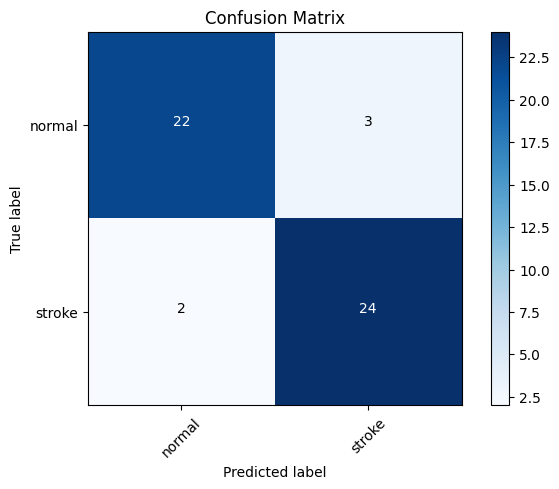

Test loss: 1.5106072425842285, Test accuracy 0.9019607901573181


In [6]:
predictions = model_customCNN.predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# Extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

# CNN (eyes)

In [26]:
lr = 0.0001

model_customCNN2 = Sequential()
model_customCNN2.add(Conv2D(
        filters=256,
        kernel_size=(6, 6),
        activation="relu",
        padding="same",
        input_shape=(img_height_eyes, img_width_eyes, 3),
    ))
model_customCNN2.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN2.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN2.add(MaxPool2D(pool_size=(4, 4), strides=4))
model_customCNN2.add(Conv2D(filters=512, kernel_size=(9, 9), activation="relu", padding="same"))
model_customCNN2.add(MaxPool2D(pool_size=(4, 4), strides=4))

model_customCNN2.add(Flatten())
model_customCNN2.add(Dense(512, activation="relu"))
model_customCNN2.add(Dense(units=2, activation="softmax"))

#model_customCNN2.summary()

model_customCNN2.compile(
    optimizer=Adam(learning_rate=lr),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model_customCNN2.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

# Save the weights
model_customCNN2.save_weights("eyes_weights.h5")
score = model_customCNN2.evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

Epoch 1/10


c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


383/383 - 402s - loss: 2.8550 - accuracy: 0.7707 - val_loss: 0.7115 - val_accuracy: 0.6746 - 402s/epoch - 1s/step
Epoch 2/10
383/383 - 390s - loss: 0.1030 - accuracy: 0.9605 - val_loss: 1.0034 - val_accuracy: 0.7041 - 390s/epoch - 1s/step
Epoch 3/10
383/383 - 396s - loss: 0.0366 - accuracy: 0.9869 - val_loss: 1.0852 - val_accuracy: 0.6923 - 396s/epoch - 1s/step
Epoch 4/10
383/383 - 396s - loss: 0.0788 - accuracy: 0.9752 - val_loss: 1.4082 - val_accuracy: 0.6982 - 396s/epoch - 1s/step
Epoch 5/10
383/383 - 393s - loss: 0.0300 - accuracy: 0.9918 - val_loss: 1.1431 - val_accuracy: 0.6982 - 393s/epoch - 1s/step
Epoch 6/10
383/383 - 393s - loss: 0.0640 - accuracy: 0.9794 - val_loss: 2.3313 - val_accuracy: 0.6686 - 393s/epoch - 1s/step
Epoch 7/10
383/383 - 393s - loss: 0.0192 - accuracy: 0.9928 - val_loss: 1.7970 - val_accuracy: 0.6686 - 393s/epoch - 1s/step
Epoch 8/10
383/383 - 396s - loss: 0.0648 - accuracy: 0.9843 - val_loss: 1.7479 - val_accuracy: 0.6667 - 396s/epoch - 1s/step
Epoch 9/10


Sensitivity: 0.8888888888888888
Specificity: 0.875
Confusion matrix, without normalization
[[7 1]
 [1 8]]


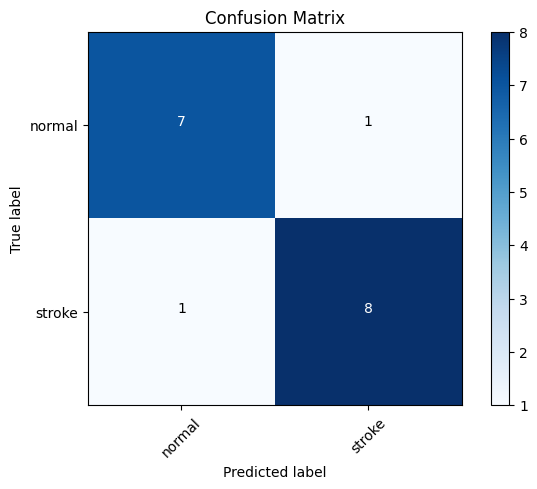

Test loss: 0.9892070889472961, Test accuracy 0.8823529481887817


In [27]:
predictions = model_customCNN2.predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# Extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))

# Pretrained Residual NN model (ResNet)

In [7]:
scores_resnet = []
models_resnet = []

for lr in param_grid["learning_rate"]:
    for layers in param_grid["hidden_layers"]:
        print("Learning rate:", lr)
        print("Layers:", layers)
    
        # Create the base ResNet152 model
        base_model = ResNet152(weights="imagenet", include_top=False, input_shape=input_shape_mouth)
    
        # Add a global average pooling layer and a dense layer with softmax activation for classification
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        for i in range(layers):
            x = Dense(128, activation="relu")(x)
        predictions = Dense(2, activation="softmax")(x)
    
        # Define the model to be trained with the ResNet152 base and the classification layers added
        model_resnet = Model(inputs=base_model.input, outputs=predictions)
    
        # Freeze the base ResNet152 layers so they are not updated during training
        for layer in base_model.layers:
            layer.trainable = False
    
        # Compile the model
        model_resnet.compile(
            optimizer=Adam(lr=lr), loss="categorical_crossentropy", metrics=["accuracy"]
        )
    
        model_resnet.fit(x=train_batches, validation_data=valid_batches, epochs=5, verbose=2)
        score = model_resnet.evaluate(test_batches, verbose=0)
    
        print("Test loss: {}, Test accuracy {}".format(score[0], score[1]))
        
        scores_resnet.append(score)
        models_resnet.append(model_resnet)

print(scores_resnet)


Learning rate: 0.0001
Layers: 1


c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\AndreiBorg\anaconda3\envs\tf\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/5
443/443 - 256s - loss: 0.3145 - accuracy: 0.8728 - val_loss: 0.3132 - val_accuracy: 0.9333 - 256s/epoch - 578ms/step
Epoch 2/5
443/443 - 207s - loss: 0.1862 - accuracy: 0.9338 - val_loss: 0.2644 - val_accuracy: 0.9350 - 207s/epoch - 467ms/step
Epoch 3/5
443/443 - 310s - loss: 0.1310 - accuracy: 0.9550 - val_loss: 0.2361 - val_accuracy: 0.9265 - 310s/epoch - 701ms/step
Epoch 4/5
443/443 - 224s - loss: 0.0930 - accuracy: 0.9731 - val_loss: 0.2455 - val_accuracy: 0.9402 - 224s/epoch - 505ms/step
Epoch 5/5
443/443 - 312s - loss: 0.0722 - accuracy: 0.9796 - val_loss: 0.2160 - val_accuracy: 0.9350 - 312s/epoch - 703ms/step
Test loss: 0.7147079110145569, Test accuracy 0.7843137383460999
Learning rate: 0.0001
Layers: 2
Epoch 1/5
443/443 - 383s - loss: 0.2982 - accuracy: 0.8787 - val_loss: 0.3065 - val_accuracy: 0.9368 - 383s/epoch - 866ms/step
Epoch 2/5
443/443 - 220s - loss: 0.1528 - accuracy: 0.9457 - val_loss: 0.2367 - val_accuracy: 0.9248 - 220s/epoch - 498ms/step
Epoch 3/5
443/4

Test loss: 0.7998781204223633, Test accuracy: 0.8235294222831726
Sensitivity: 0.8846153846153846
Specificity: 0.76
Confusion matrix, without normalization
[[19  6]
 [ 3 23]]


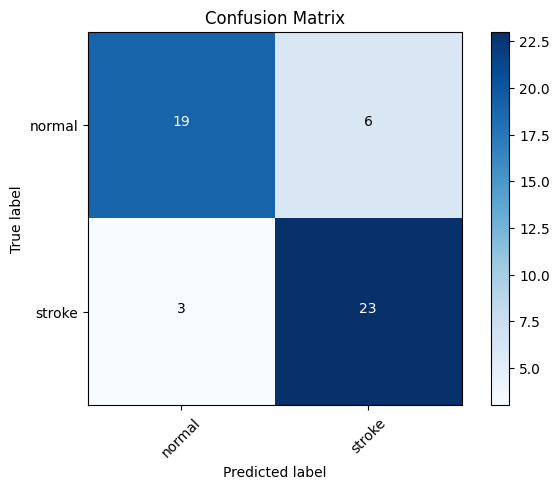

In [8]:
score = models_resnet[2].evaluate(test_batches, verbose=0)

print("Test loss: {}, Test accuracy: {}".format(score[0], score[1]))

# Pick the best model, index 2 in this case
predictions = models_resnet[2].predict(x=test_batches, verbose=0)

np.round(predictions)

cm = confusion_matrix(
    y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1)
)

# Extract true positives, false positives, true negatives, and false negatives
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

cm_plot_labels = ["normal", "stroke"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")